In [26]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_hist,...,Money_Flow,Pos_Flow,Neg_Flow,MFI,MACD_Strategy,MFI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
2065,43.849998,43.910000,43.849998,43.910000,1331,43.826883,43.797054,0.029828,0.018050,0.011778,...,5.839097e+04,0.000000,43.869999,53.869061,NaN,NaN,NaN,0,NaN,NaN
2066,43.880001,43.880001,43.880001,43.880001,242,43.835781,43.805884,0.029897,0.020506,0.009391,...,1.061896e+04,43.880001,0.000000,57.170820,1.0,0.0,1.0,0,0.000684,0.000000
2067,43.740002,43.779999,43.740002,43.779999,1776,43.819953,43.799108,0.020845,0.020575,0.000269,...,7.770592e+04,0.000000,43.753334,50.047426,1.0,0.0,1.0,0,-0.002508,0.000000
2068,43.535000,43.645000,43.535000,43.645000,887,43.773393,43.772772,0.000622,0.016493,-0.015871,...,3.864807e+04,0.000000,43.571667,42.922859,1.0,0.0,1.0,0,-0.007184,0.000000
2069,43.525002,43.525002,43.419998,43.509998,1900,43.733192,43.748744,-0.015552,0.009966,-0.025519,...,8.263100e+04,0.000000,43.490000,42.941538,-1.0,0.0,-1.0,0,-0.007412,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,60.645000,60.750000,60.630001,60.665001,8720,60.842322,60.987845,-0.145522,-0.115195,-0.030327,...,5.290860e+05,0.000000,60.675001,35.746674,-1.0,1.0,0.0,0,0.383010,-0.018699
3048,60.505001,60.564999,60.450001,60.544998,13874,60.790427,60.953356,-0.162929,-0.124742,-0.038187,...,8.394695e+05,0.000000,60.506667,35.769196,-1.0,1.0,0.0,0,0.379818,-0.018699
3049,60.549999,60.580002,60.430000,60.470001,8477,60.753438,60.924545,-0.171107,-0.134015,-0.037092,...,5.130280e+05,60.520000,0.000000,42.898279,-1.0,1.0,0.0,0,0.380844,-0.018699
3050,60.320000,60.480000,60.205002,60.480000,26099,60.686755,60.881363,-0.194608,-0.146134,-0.048474,...,1.574683e+06,0.000000,60.335000,42.926352,-1.0,0.0,-1.0,0,0.375599,-0.018699


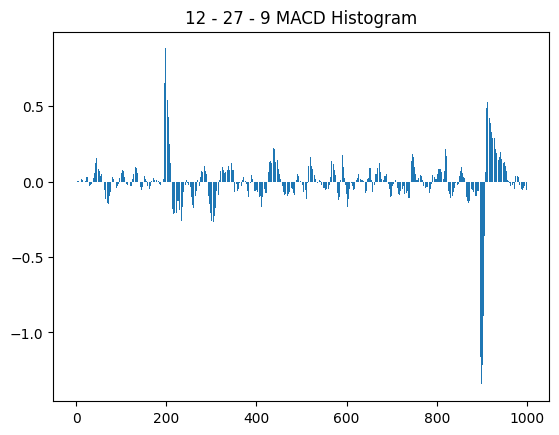

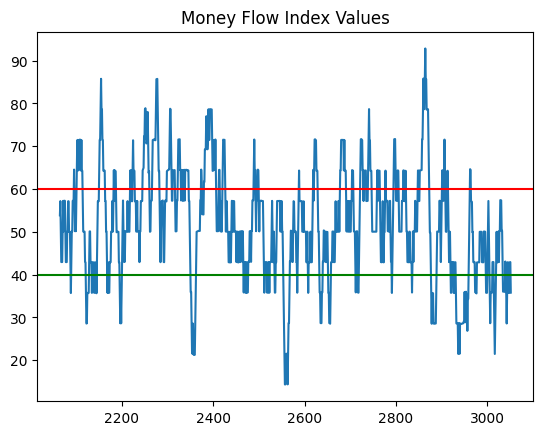

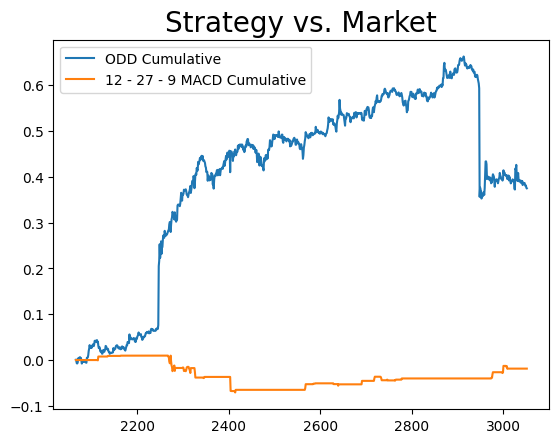

In [27]:
TICKER = 'ODD'
INTERVAL='5m'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

MFI_LENGTH = 14
OVERBOUGHT = 60
OVERSOLD = 40
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):

    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    # macd line is the difference betweent he fast and slow
    df[f'MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema']

    # macd signal is a 9-period moving average of this line
    df['Signal'] = df['MACD'].ewm(span=span).mean()

    # MACD histogram is almost always what is used in TA
    df['MACD_hist'] = df['MACD'] - df['Signal']

    # plot the histogram
    plt.bar(x=range(len(df)), height=df['MACD_hist'])
    plt.title(f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Histogram')

    return df

def add_MACD_strategy(df):

    df['MACD_Strategy'] = 0
    df['MACD_Strategy'] = np.where(df['MACD_hist'] > 0, 1, -1)
    df['MACD_Strategy'] = df['MACD_Strategy'].shift(1)
    return df

def add_MFI(df, length=MFI_LENGTH):

    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_Flow'] = df['Volume'] * df['Average_Price']
 
    # initialize empty flows
    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0

    df['Pos_Flow'] = np.where(df['Average_Price'].diff() > 0, df['Average_Price'], 0)
    df['Neg_Flow'] = np.where(df['Average_Price'].diff() < 0, df['Average_Price'], 0)

    mfr = df['Pos_Flow'].rolling(length).sum() / df['Neg_Flow'].rolling(length).sum()

    # add money flow column
    df['MFI'] = 100 - (100 / (1 + mfr))

    plt.figure()
    plt.plot(df['MFI'])
    plt.axhline(OVERBOUGHT, color='red')
    plt.axhline(OVERSOLD, color='green')
    plt.title('Money Flow Index Values');
        
    return df.dropna()

def add_MFI_strategy(df, overbought=OVERBOUGHT, oversold=OVERSOLD):

    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1, 
                     np.where(df['MFI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['MACD_Strategy'] + df['MFI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_MACD_strategy(df)
    df = add_MFI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()
df